In [13]:
import os
import random
import torch
import kagglehub
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from EnhanceAndSharpen import HistogramEnhanceAndSharpen
from SimpleCNN import SimpleCNN
from RemoveBackground import RemoveBackground
from torch.utils.data import DataLoader, Subset, random_split
from collections import Counter


In [14]:


# Download latest version
path = kagglehub.dataset_download("kaggleashwin/vehicle-type-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\kaggleashwin\vehicle-type-recognition\versions\1


In [15]:
# Hiển thị các tệp và thư mục con trong thư mục dataset
print("Contents:", os.listdir(path))


Contents: ['Dataset']


In [16]:
dataset_path = os.path.join(path, "Dataset")
print("Contents in Dataset:", os.listdir(dataset_path))


Contents in Dataset: ['Bus', 'Car', 'motorcycle', 'Truck']


In [17]:
# Augmentation chỉ cho tập huấn luyện
train_transform = transforms.Compose([
    RemoveBackground(),
    HistogramEnhanceAndSharpen(
        dark_pixel_ratio_thresh=0.6,
        brightness_factor=1.2,
        contrast_factor=1.2,
        apply_sharpen=True
    ),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Transform không thay đổi cho val/test
test_val_transform = transforms.Compose([
    RemoveBackground(),
    HistogramEnhanceAndSharpen(
        dark_pixel_ratio_thresh=0.6,
        brightness_factor=1.2,
        contrast_factor=1.2,
        apply_sharpen=True
    ),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [18]:

full_dataset = ImageFolder(dataset_path)
print(" Classes:", full_dataset.classes)

# Kiểm tra số lượng ảnh mỗi lớp
label_counts = Counter([label for _, label in full_dataset])
for class_idx, count in label_counts.items():
    print(f" Class {full_dataset.classes[class_idx]}: {count} images")

# Chia tập
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len   = int(0.15 * total_len)
test_len  = total_len - train_len - val_len

train_idx, val_idx, test_idx = random_split(range(total_len), [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# Áp dụng transform riêng bằng Subset
train_dataset = Subset(ImageFolder(dataset_path, transform=train_transform), train_idx.indices)
val_dataset   = Subset(ImageFolder(dataset_path, transform=test_val_transform), val_idx.indices)
test_dataset  = Subset(ImageFolder(dataset_path, transform=test_val_transform), test_idx.indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

 Classes: ['Bus', 'Car', 'Truck', 'motorcycle']


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 Class Bus: 100 images
 Class Car: 100 images
 Class Truck: 100 images
 Class motorcycle: 100 images


Label classes: ['Bus', 'Car', 'Truck', 'motorcycle']
Labels batch: tensor([3, 3, 2, 0, 3, 3, 3, 2, 2, 3, 3, 2, 3, 1, 1, 1, 0, 1, 1, 3, 1, 2, 1, 0,
        2, 1, 3, 2, 1, 3, 0, 0])


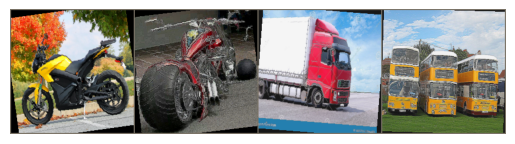

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Lấy 1 batch ảnh từ dataloader
images, labels = next(iter(train_loader))
print("Label classes:", full_dataset.classes)
print("Labels batch:", labels)

# Hiển thị ảnh  
imshow(torchvision.utils.make_grid(images[:4]))


In [20]:
from SimpleCNN import SimpleCNN

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # In báo cáo
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    print("📉 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [23]:

model = SimpleCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


class_names = ['Bus', 'Car', 'motorcycle', 'Truck']

print("\n Final Test Evaluation:")
evaluate(model, test_loader, class_names)



 Final Test Evaluation:

📊 Classification Report:
              precision    recall  f1-score   support

         Bus     0.7273    0.4706    0.5714        17
         Car     0.5000    0.4118    0.4516        17
  motorcycle     0.3684    0.4375    0.4000        16
       Truck     0.4375    0.7000    0.5385        10

    accuracy                         0.4833        60
   macro avg     0.5083    0.5050    0.4904        60
weighted avg     0.5189    0.4833    0.4863        60

📉 Confusion Matrix:
[[8 1 6 2]
 [1 7 5 4]
 [2 4 7 3]
 [0 2 1 7]]


In [ ]:
def predict_image(image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = test_val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
        class_name = full_dataset.classes[pred]
        return class_name


print(predict_image("image.jpg"))

motorcycle
